In [4]:
import datetime
import os
import numpy as np
import cv2
import imageio
from dateutil.relativedelta import relativedelta
from scipy.stats import multivariate_normal
from scipy.cluster.vq import kmeans2
import matplotlib.pyplot as plt

# Function to read an image from a file, convert it to the specified mode, and apply downsampling
def load_and_preprocess_image(filepath, color_mode, resize_scale):
    if not os.path.exists(filepath):
        print(f"File not found: {filepath}")
        return None

    # Load image in BGR color space using OpenCV
    img_bgr = cv2.imread(filepath)
    if img_bgr is None:
        print(f"Failed to load image: {filepath}")
        return None

    # Convert color space if required
    if color_mode == 'RGB':
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    elif color_mode == 'L':
        img_rgb = imageio.imread(filepath, pilmode='L')

    # Resize image to the specified scale
    img_resized = cv2.resize(img_rgb, (0, 0), fx=resize_scale[0], fy=resize_scale[1])
    # Apply a Gaussian blur to the resized image
    img_blurred = cv2.blur(img_resized, (4, 4))
    return img_blurred

# Function to flatten a 3D image array to a 2D array
def flatten_image(img):
    if img.ndim == 3:
        x, y, z = img.shape
        img_flattened = img.reshape(x * y, z)
    elif img.ndim == 2:
        x, y = img.shape
        img_flattened = img.reshape(x * y, 1)
    return img_flattened.astype(float)

def reconstruct_image(img_flattened, width, height, color_mode='RGB'):
    if color_mode == 'RGB':
        # Assumes the input is normalized (0 to 1), scales to 0-255, and converts to uint8.
        img_2d = (img_flattened * 255).astype(np.uint8)
        reconstructed_img = img_2d.reshape(height, width, 3)
    elif color_mode == 'L':
        # For grayscale, simply reshapes without changing the color depth.
        img_2d = (img_flattened * 255).astype(np.uint8)
        reconstructed_img = img_2d.reshape(height, width)

    return reconstructed_im


# Initialize K-means clustering
def kmeans_initialization(img, num_clusters):
    means, labels = kmeans2(img, num_clusters)
    covariance_matrices = np.array([np.cov(img[labels == i].T) for i in range(num_clusters)])
    probabilities = np.array([np.mean(labels == i) for i in range(num_clusters)])
    return means, covariance_matrices, probabilities

def random_initialization(img, num_clusters):
    num_features = img.shape[1]
    means = np.random.randint(np.min(img), np.max(img), size=(num_clusters, num_features))
    covariances = np.array([np.eye(num_features) * np.var(img, axis=0) for _ in range(num_clusters)])
    probabilities = np.random.rand(num_clusters)
    probabilities /= probabilities.sum()
    return means, covariances, probabilities

# Function to update cluster responsibilities during the E-step of the EM algorithm
def update_responsibilities(img, cluster_means, cluster_covariances, cluster_probabilities):
    num_clusters = len(cluster_probabilities)
    responsibilities = np.array([cluster_probabilities[j] * multivariate_normal.pdf(img, mean=cluster_means[j], cov=cluster_covariances[j]) for j in range(num_clusters)]).T
    responsibilities /= responsibilities.sum(axis=1, keepdims=True)
    return responsibilities

# Update cluster means during the M-step of the EM algorithm
def update_cluster_means(img, responsibilities):
    weighted_sum = np.dot(responsibilities.T, img)
    cluster_sizes = responsibilities.sum(axis=0)
    new_means = weighted_sum / cluster_sizes[:, None]
    return new_means

def update_covariances(img, responsibilities, means):
    num_clusters = len(means)
    covariances = []
    for j in range(num_clusters):
        diff = img - means[j]
        weighted_diff = responsibilities[:, j][:, np.newaxis] * diff
        cov_j = np.dot(weighted_diff.T, diff) / responsibilities[:, j].sum()
        covariances.append(cov_j)
    return np.array(covariances)

def update_probabilities(responsibilities):
    return responsibilities.sum(axis=0) / responsibilities.shape[0]

# Function to compute the log-likelihood of the current model
def compute_log_likelihood(img, cluster_means, cluster_covariances, cluster_probabilities):
    num_clusters = len(cluster_probabilities)
    log_likelihood = np.log(np.sum([cluster_probabilities[j] * multivariate_normal.pdf(img, mean=cluster_means[j], cov=cluster_covariances[j]) for j in range(num_clusters)], axis=0))
    return np.sum(log_likelihood)

# EM algorithm to cluster image data
def em_clustering(img, num_clusters, use_random_init=False, convergence_threshold=1e-4, max_iterations=1000):
    # Initialize cluster parameters
    # If use_random_init is True, initialize parameters randomly
    # Otherwise, use K-means for initialization
    if use_random_init:
        means, covariances, probabilities = random_initialization(img, num_clusters)
    else:
        means, covariances, probabilities = kmeans_initialization(img, num_clusters)

    # Initialize log likelihood to a very low number
    log_likelihood = -np.inf

    # Start the EM iteration
    for iteration in range(max_iterations):
        start_time = datetime.datetime.now()

        # E-step: Calculate responsibilities (i.e., the probability of each point belonging to each cluster)
        responsibilities = update_responsibilities(img, means, covariances, probabilities)

        # M-step: Update the parameters of each cluster based on the new responsibilities
        means = update_cluster_means(img, responsibilities)          # Update means
        covariances = update_covariances(img, responsibilities, means)  # Update covariances
        probabilities = update_probabilities(responsibilities)          # Update mixture probabilities

        # Calculate the new log likelihood of the data given the updated parameters
        new_log_likelihood = compute_log_likelihood(img, means, covariances, probabilities)

        # Check for convergence: if the improvement in log likelihood is less than the threshold, stop
        if abs(new_log_likelihood - log_likelihood) < convergence_threshold:
            print(f"Convergence reached after {iteration + 1} iterations.")
            break
        log_likelihood = new_log_likelihood

        end_time = datetime.datetime.now()
        print(f"Iteration {iteration + 1}, Time: {end_time - start_time}, Log-Likelihood: {new_log_likelihood}")

    # Return the final cluster parameters
    return means, covariances, probabilities

# Example usage:
image = load_and_preprocess_image('peppers_color.tif', 'RGB', (0.5, 0.5))
flat_image = flatten_image(image)
means, covs, pis = em_clustering(flat_image, 3)


Iteration 1, Time: 0:00:00.053860, Log-Likelihood: -920307.7239064383
Iteration 2, Time: 0:00:00.054862, Log-Likelihood: -919161.3612601791
Iteration 3, Time: 0:00:00.048869, Log-Likelihood: -918485.1342999216
Iteration 4, Time: 0:00:00.048873, Log-Likelihood: -917896.6815976265
Iteration 5, Time: 0:00:00.045881, Log-Likelihood: -917238.1596681293
Iteration 6, Time: 0:00:00.061838, Log-Likelihood: -916615.3099176604
Iteration 7, Time: 0:00:00.061840, Log-Likelihood: -916126.9276400461
Iteration 8, Time: 0:00:00.077798, Log-Likelihood: -915767.7977151097
Iteration 9, Time: 0:00:00.056850, Log-Likelihood: -915513.3941607563
Iteration 10, Time: 0:00:00.057850, Log-Likelihood: -915336.2903687148
Iteration 11, Time: 0:00:00.073808, Log-Likelihood: -915211.7608077112
Iteration 12, Time: 0:00:00.051864, Log-Likelihood: -915123.4642815387
Iteration 13, Time: 0:00:00.046878, Log-Likelihood: -915060.5311001687
Iteration 14, Time: 0:00:00.048906, Log-Likelihood: -915015.4576899059
Iteration 15, T

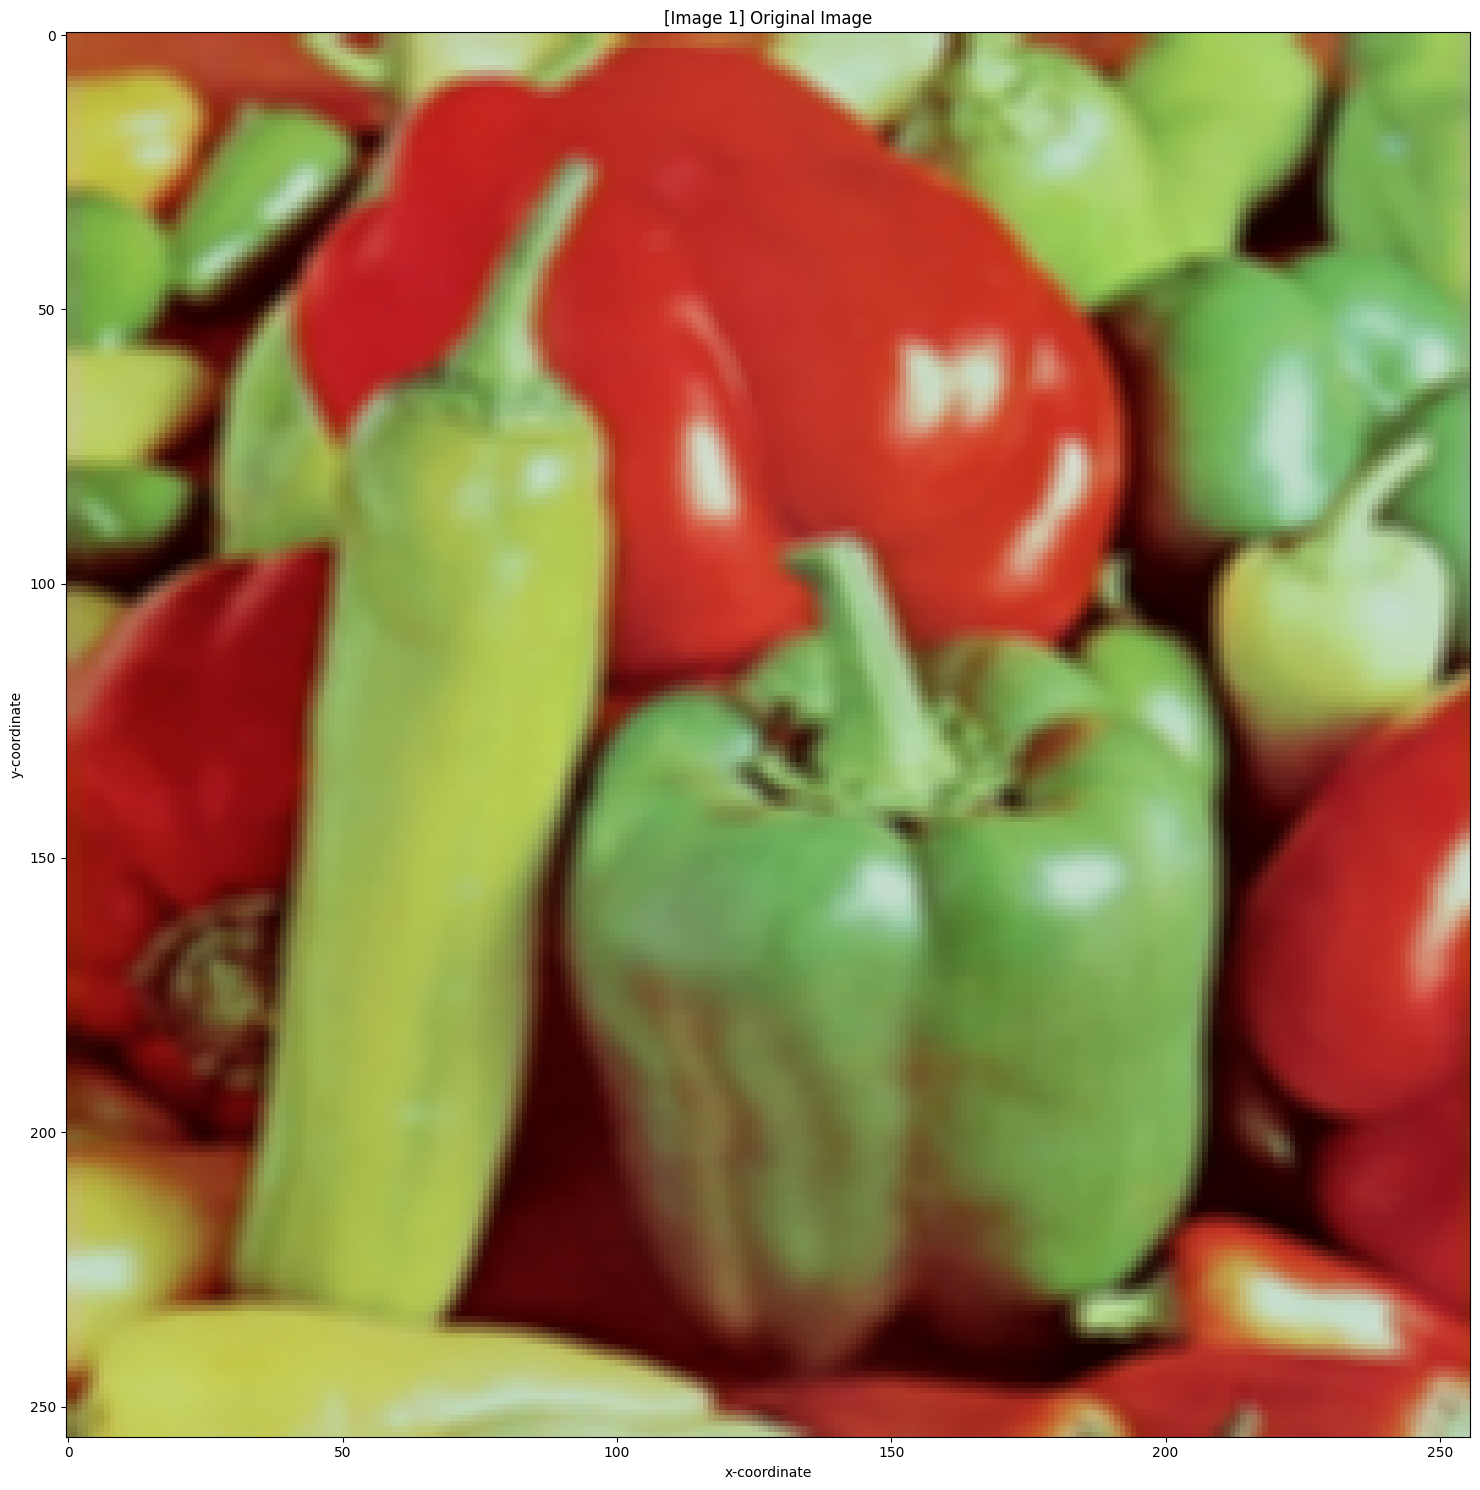

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.cluster.vq import kmeans2, whiten

# Function to compute the probability density function (PDF) for a given data point
def compute_pdf(data_point, cluster_means, cluster_covariances, cluster_probabilities, num_clusters):
    pdf_values = np.array([cluster_probabilities[j] * multivariate_normal.pdf(data_point, mean=cluster_means[j], cov=cluster_covariances[j])
                           for j in range(num_clusters)])
    total_pdf = np.sum(pdf_values)
    return total_pdf

# File list of images to process
filename_list = ['peppers_color.tif']

# Prepare to visualize original images
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
image_data_list = []
image_dimensions_list = []
image_index = 1

# Process and display each image
for filename in filename_list:
    # Load and preprocess the image
    image_rgb = load_and_preprocess_image(filename, 'RGB', (0.5, 0.5))
    if image_rgb is not None:
        height, width, channels = image_rgb.shape

        # Store image dimensions
        image_dimensions_list.append((height, width, channels))
        # Store image data
        image_data_list.append(image_rgb)

        # Display the original image
        ax.imshow(image_rgb)
        ax.set_title(f'[Image {image_index}] Original Image')
        ax.set_xlabel('x-coordinate')
        ax.set_ylabel('y-coordinate')
        image_index += 1

plt.tight_layout()
fig.savefig('original_images.pdf')



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


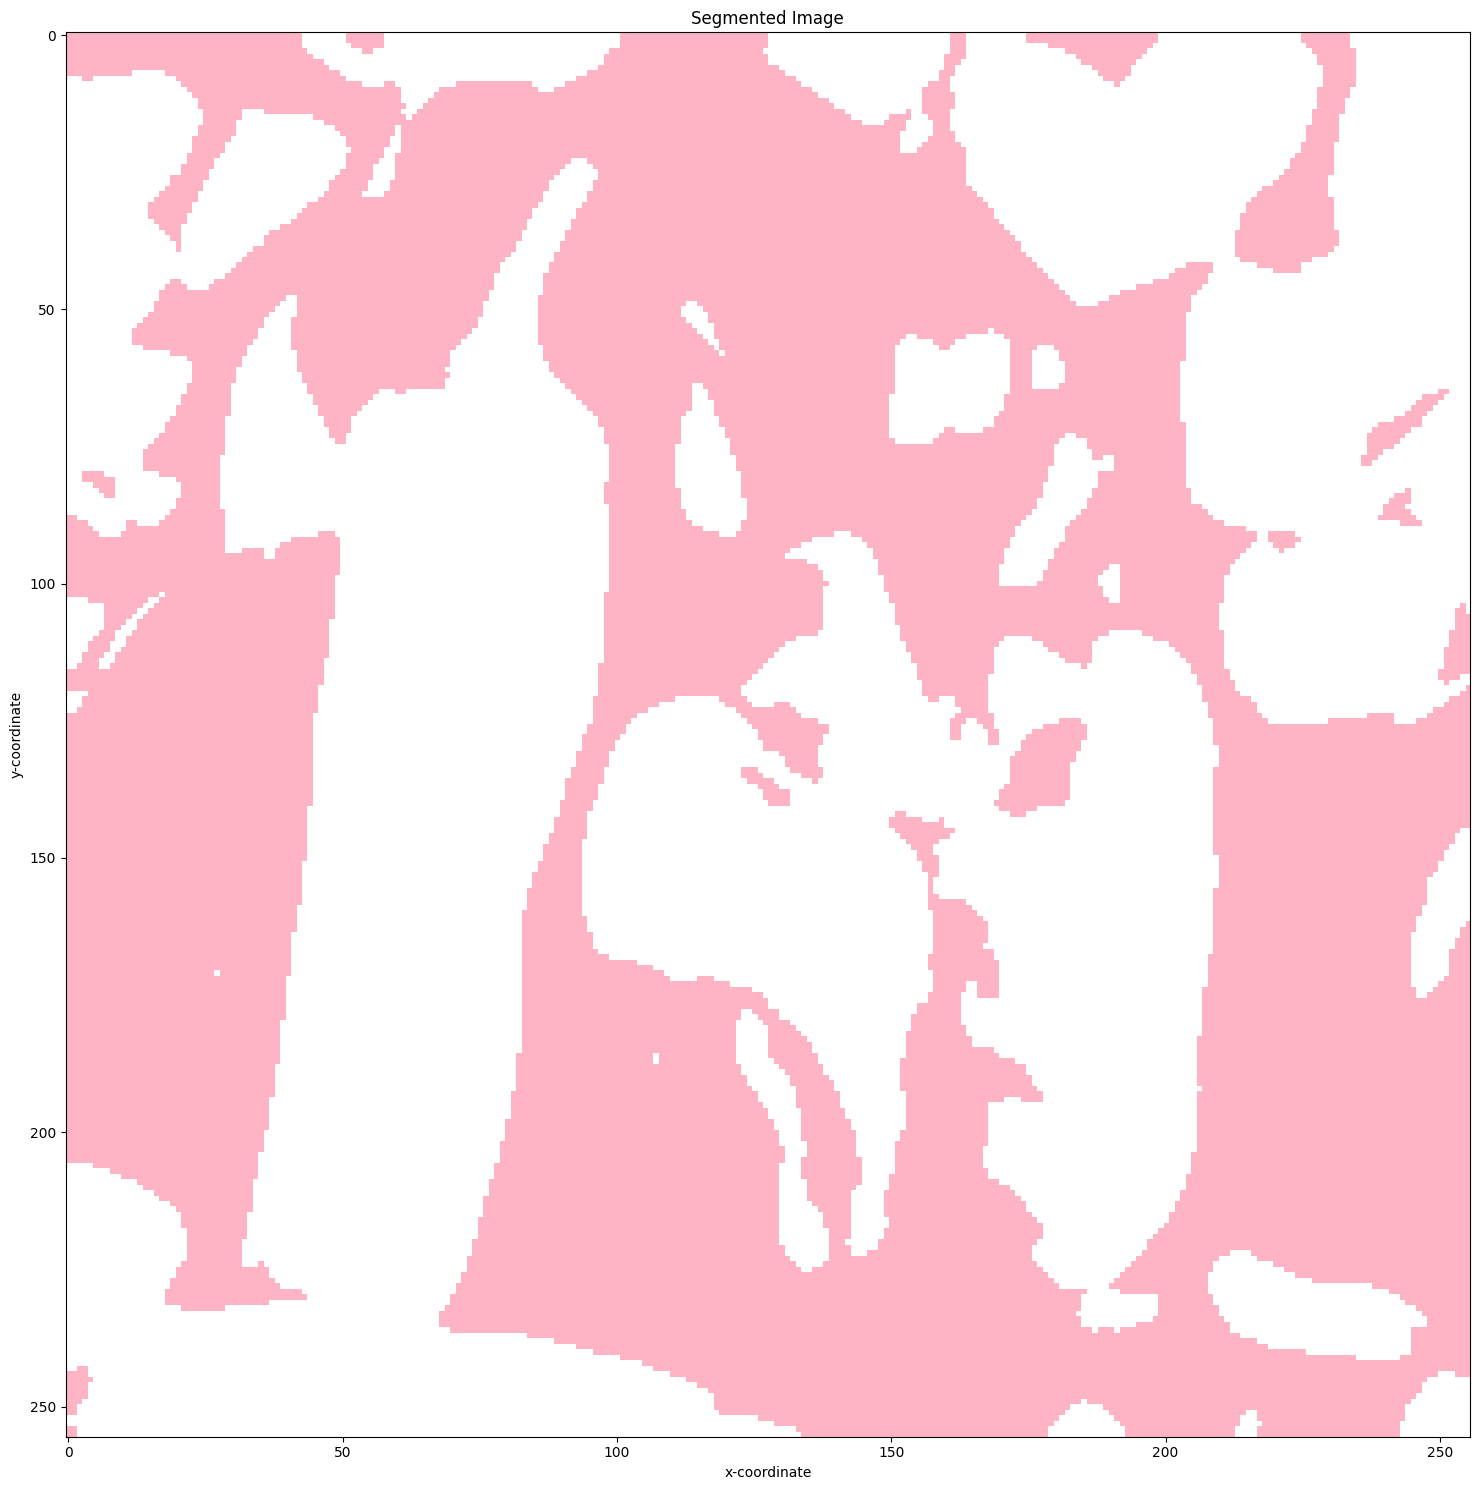

In [9]:
def display_segmented_images(images, title_prefix='Segmented Image'):
    fig, axes = plt.subplots(1, len(images), figsize=(15 * len(images), 15))
    if len(images) == 1:
        axes = [axes]  # Make sure axes is iterable

    for ax, image in zip(axes, images):
        if image.ndim == 3:
            ax.imshow(image)
        else:
            ax.imshow(image, cmap='gray')  # For grayscale images
        ax.set_title(f'{title_prefix}')
        ax.set_xlabel('x-coordinate')
        ax.set_ylabel('y-coordinate')
        #ax.axis('off')

    plt.tight_layout()
    plt.show()

# Assuming image_data_list and image_dimensions_list are populated correctly
flattened_images = [image.reshape(-1, image.shape[2]) for image in image_data_list]  # Ensure it flattens to 2D

kmeans_clustered_images = []
for flattened_image, dimensions in zip(flattened_images, image_dimensions_list):
    # Normalize data for clustering
    normalized_image = whiten(flattened_image)
    cluster_centers, cluster_labels = kmeans2(normalized_image, 2, minit='points')

    # Create a clustered image by mapping each pixel to the cluster center it belongs to
    clustered_image = np.array([cluster_centers[label] for label in cluster_labels])
    clustered_image = clustered_image.reshape(dimensions[0], dimensions[1], dimensions[2] if len(dimensions) > 2 else 1)

    kmeans_clustered_images.append(clustered_image)

# Display all clustered images
display_segmented_images(kmeans_clustered_images)